In [138]:
import gzip
import json
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import networkx as nx
import torch
from torch import tensor
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from partitioning import KL
from torch_geometric.utils.convert import from_scipy_sparse_matrix
import random

In [4]:
with gzip.open('../data/xbar/1/xbar.json.gz','rb') as f:
    design = json.loads(f.read().decode('utf-8'))
    
instances = pd.DataFrame(design['instances'])
nets = pd.DataFrame(design['nets'])

conn=np.load('../data/xbar/1/xbar_connectivity.npz')
A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
A = A.__mul__(A.T)

def buildBST(array,start=0,finish=-1):
    if finish<0:
        finish = len(array)
    mid = (start + finish) // 2
    if mid-start==1:
        ltl=start
    else:
        ltl=buildBST(array,start,mid)
    
    if finish-mid==1:
        gtl=mid
    else:
        gtl=buildBST(array,mid,finish)
        
    return((array[mid],ltl,gtl))

congestion_data = np.load('../data/xbar/1/xbar_congestion.npz')
xbst=buildBST(congestion_data['xBoundaryList'])
ybst=buildBST(congestion_data['yBoundaryList'])
demand = np.zeros(shape = [instances.shape[0],])


def getGRCIndex(x,y,xbst,ybst):
    while (type(xbst)==tuple):
        if x < xbst[0]:
            xbst=xbst[1]
        else:
            xbst=xbst[2]
            
    while (type(ybst)==tuple):
        if y < ybst[0]:
            ybst=ybst[1]
        else:
            ybst=ybst[2]
            
    return ybst, xbst


for k in range(instances.shape[0]):
    #print(k)
    xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
    i,j=getGRCIndex(xloc,yloc,xbst,ybst)
    d = 0 
    for l in list(congestion_data['layerList']): 
        lyr=list(congestion_data['layerList']).index(l)
        d += congestion_data['demand'][lyr][i][j]
    demand[k] = d
        
instances['routing_demand'] = demand

In [117]:
instances

,name,id,xloc,yloc,cell,orient,routing_demand
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0
...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0
3948,U4125,3948,33664,66048,42,0,30.0
3949,U4128,3949,23296,66048,34,0,27.0
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0


In [118]:
G = nx.from_scipy_sparse_array(A)

In [188]:
partitions = KL(G, 3)
partitions

In [189]:
def create_partition_map(partitions):
    """
    Creates a mapping of nodes to their corresponding partition indices.

    :param partitions: A list of sets, where each set contains nodes belonging to a partition.
    :return: A dictionary with nodes as keys and their corresponding partition index as values.
    """
    node_partition_map = {}
    for index, partition in enumerate(partitions):
        for node in partition:
            node_partition_map[node] = index
    return node_partition_map

In [190]:
def compute_cross_edge_weight(G, partitions):
    node_partition_map = create_partition_map(partitions)
    cross_edge_weight = 0

    for u, v in G.edges():
        if node_partition_map.get(u) != node_partition_map.get(v):  # Check if nodes are in different partitions
            cross_edge_weight += 1  # Assuming unweighted edges

    return cross_edge_weight

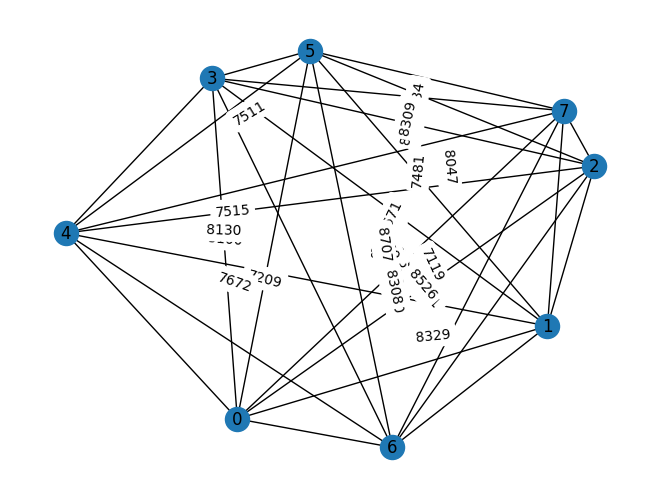

In [191]:
def supergraph(G, partitions):
    """
    Constructs a super graph from the original graph where each node represents a partition,
    and the edges represent the cross-edge weights between partitions.

    :param G: A NetworkX graph.
    :param partitions: A list of sets, where each set contains nodes belonging to a partition.
    :return: A super graph where each node represents a partition and edges represent cross-edge weights.
    """
    out = nx.Graph()
    for i in range(len(partitions)):
        out.add_node(i)  # Add a node for each partition

    for i in range(len(partitions)):
        for j in range(i + 1, len(partitions)):
            weight = compute_cross_edge_weight(G, [partitions[i], partitions[j]])
            out.add_edge(i, j, weight=weight)

    return out

super_G = supergraph(G, partitions)
pos = nx.spectral_layout(super_G)
nx.draw(super_G, with_labels=True)
edge_labels = nx.get_edge_attributes(super_G, 'weight')
nx.draw_networkx_edge_labels(super_G, pos, edge_labels = edge_labels);

In [192]:
def random_walk(G, start_node, length):
    walk = [start_node]
    for _ in range(length-1):
        current_node = walk[-1]
        neighbors = list(G.neighbors(current_node))
        if neighbors:
            next_node = random.choice(neighbors)
            walk.append(next_node)
        else:
            break
    return walk

# Perform random walk on super_graph
walk_length=3
start_node = random.choice(list(super_G.nodes()))
walk = random_walk(super_G, start_node, walk_length)

In [193]:
super_batch = G.subgraph(walk)

In [194]:
walk_partitions = []
random_nodes = []
for node in walk:
    current_partition = partitions[node]
    random_node = np.random.choice(current_partition)
    random_nodes.append(random_node)
    walk_partitions.append(current_partition)
batched_graph = nx.compose_all(walk_partitions)

In [195]:
import itertools
# Add edges between every combination of random nodes to create a fully connected subgraph
for node1, node2 in itertools.combinations(random_nodes, 2):
    batched_graph.add_edge(node1, node2)

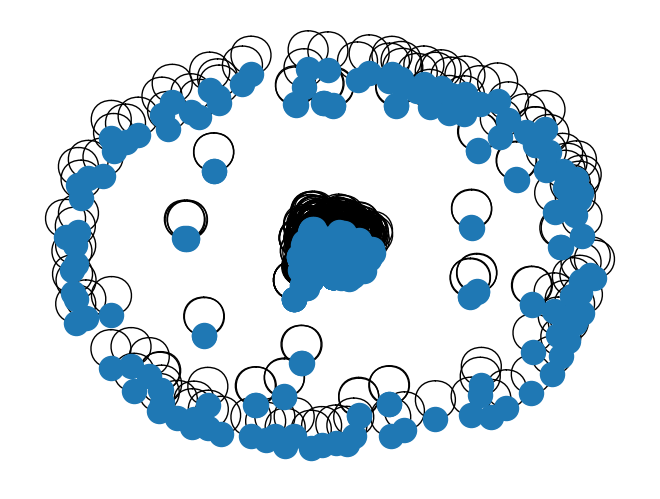

In [196]:
nx.draw(batched_graph)

now for use in congestion model